# Naive Bayes classifiers

We show how to implement Naive Bayes classifiers from scratch.
We use binary features, and 2 classes.
Based on sec 18.9 of http://d2l.ai/chapter_appendix-mathematics-for-deep-learning/naive-bayes.html.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# helper function to show images
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    p = int(np.sqrt(imgs.shape[1]))
    assert p * p == imgs.shape[1]
    # modified from https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py
    figsize = (num_cols * scale, num_rows * scale)
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs.reshape(-1, p, p))):
        img = np.array(img)
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    fig.tight_layout()
    return axes

# Get data

We use a binarized version of MNIST.


In [3]:
%%time
# mnist_784
# https://www.openml.org/search?type=data&status=active&id=554
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', return_X_y=True, as_frame=False)
X /= 255
y = y.astype('int64') # str -> int
X.shape, y.shape

CPU times: total: 14.1 s
Wall time: 14.4 s


((70000, 784), (70000,))

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [5]:
image, label = X_train[2], y_train[2]
type(image), image.shape, type(label), label

(numpy.ndarray, (784,), numpy.int64, 2)

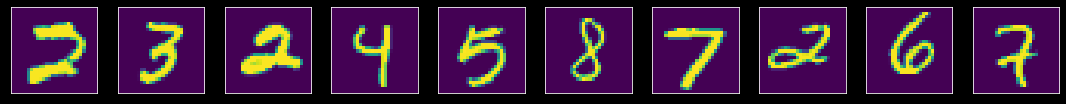

In [6]:
show_images(X_train[:10], 1, 10);

# Multivariate Bernoulli naive Bayes with scikit-learn


In [7]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train, y_train)
# Mean accuracy of the training set and the test set
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.8315, 0.8409)

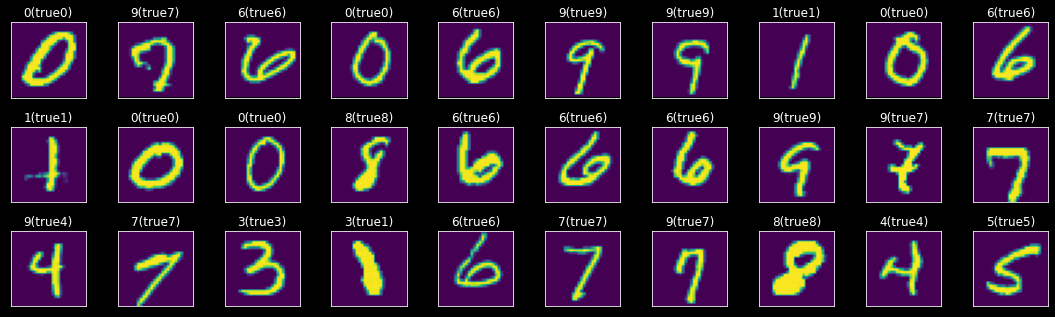

In [8]:
preds = clf.predict(X_test[:30])
show_images(X_test[:30], 3, 10, titles=[f"{d}(true{y})" for d, y in zip(preds, y_test[:30])]);

# Manual training


In [9]:
n_y = np.array([(y_train == i).sum() for i in range(10)])
P_y = n_y / n_y.sum()
P_y

array([0.09855   , 0.11228333, 0.09955   , 0.10186667, 0.09775   ,
       0.09056667, 0.09838333, 0.10398333, 0.09746667, 0.0996    ])

In [10]:
# Training set is not equally balanced across classes...
from collections import Counter
cnt = Counter(y_train)
cnt

Counter({2: 5973,
         3: 6112,
         4: 5865,
         5: 5434,
         8: 5848,
         7: 6239,
         6: 5903,
         0: 5913,
         9: 5976,
         1: 6737})

We use add-one smoothing for class conditional Bernoulli distributions.


In [11]:
n_x = np.array([X_train[y_train == i].sum(axis=0) for i in range(10)])
# using pseudo counts of 1
# P_xy = (n_x + 1) / (n_y + 1).reshape(-1, 1)
P_xy = (n_x + 1) / (n_y + 2).reshape(-1, 1)
P_xy.shape

(10, 784)

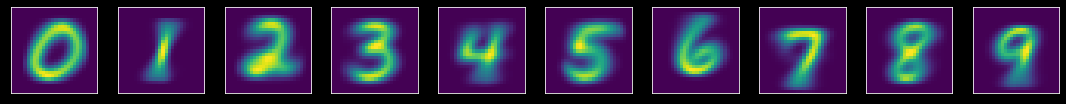

In [12]:
show_images(P_xy, 1, 10);

# Manual testing


In [13]:
log_P_xy = np.log(P_xy)
log_P_xy_neg = np.log(1 - P_xy)
log_P_y = np.log(P_y)

def bayes_pred_stable(x):
    # x = x.unsqueeze(0)  # (28, 28) -> (1, 28, 28)
    x = np.expand_dims(x, 0)  # (28, 28) -> (1, 28, 28)
    p_xy = log_P_xy * x + log_P_xy_neg * (1 - x)  # select the 0 and 1 pixels
    p_xy = p_xy.reshape(10, -1).sum(axis=1)  # p(x|y)
    return p_xy + log_P_y

def predict(X):
    return np.array([np.argmax(bayes_pred_stable(x)) for x in X])

# image, label = mnist_test[0]
image = X_test[0]
label = y_test[0]
py = bayes_pred_stable(image)
print(py)
print("ytrue ", label, "yhat ", np.argmax(py))
print(predict([image]))

[-211.92929364 -708.88640685 -366.13347373 -379.78313608 -415.7341713
 -307.01519763 -385.21632277 -544.09829672 -365.90492379 -490.1918055 ]
ytrue  0 yhat  0
[0]


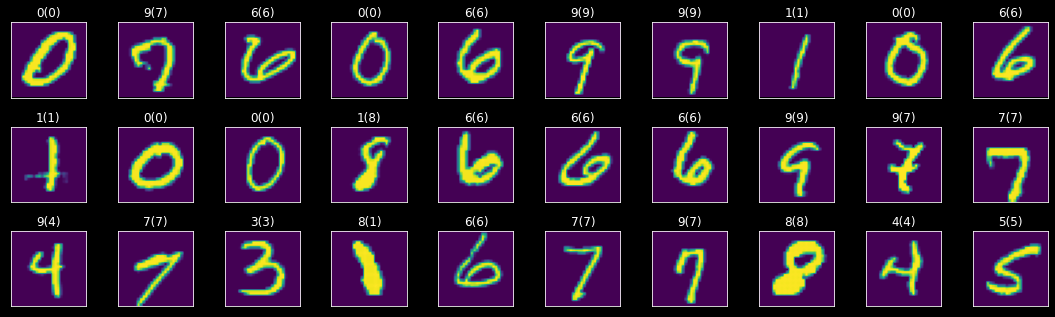

In [14]:
X1, y1 = X_test[:30], y_test[:30]
preds = predict(X1)
show_images(X1, 3, 10, titles=[f"{d}({y})" for d, y in zip(preds, y1)]);

In [15]:
preds = predict(X_test)
np.count_nonzero(preds == y_test) / len(y_test)  # test accuracy

0.8391